In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
#import xgcm
from datetime import timedelta


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34623,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:44099,Total threads: 4
Dashboard: /proxy/44749/status,Memory: 21.33 GiB
Nanny: tcp://127.0.0.1:37611,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
#Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
#Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
#Tfreezing_min = 'accessom2-GPC006'
#Tfreezing_min_bg03 = 'accessom2-GPC007'
# temperature of meltwater equal to  min( Tfreezing(s=0),Tinsitu)
#Tfreezing_min_s0 = 'accessom2-GPC008'
# calving = 0.5 * runoff, no basal
#nobasal = 'accessom2-GPC009'
# realistic calving + conservative temperature + tfreezing as in GPC006
#Tfreezing_min_calv = 'accessom2-GPC012'
# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
#realistic calving + conservative temperature + tfreezing as in GPC006 + tcalving def changed
Tfreezing_min_calvf = 'accessom2-GPC014'


start_time='2150-01-01'
end_time='2150-06-01'

lat_slice = slice(-90,-59)
lon_slice = slice(-280,80)
isobath_depth = 1000

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

#dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
#           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
#           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',
#           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC007/',
#           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC008/',
#           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC009/',
#           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC012/',
#           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/']

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC014/']
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC013


100%|██████████| 212/212 [01:00<00:00,  3.53it/s]


Indexing experiment: accessom2-GPC014


0it [00:00, ?it/s]


212

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
start_time='2151-01-01'
end_time='2152-01-01'

# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

#Import seaice
hi_con = cc.querying.getvar(control, 'hi_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_con = cc.querying.getvar(control, 'aice_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

hi_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'hi_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'aice_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

VariableNotFoundError: No files were found containing 'hi_m' in the 'accessom2-GPC014' experiment

In [8]:
# Rename coordinates
# t-grid
aice_con.coords['ni'] = area_t['xt_ocean'].values
aice_con.coords['nj'] = area_t['yt_ocean'].values
aice_con = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
hi_con.coords['ni'] = area_t['xt_ocean'].values
hi_con.coords['nj'] = area_t['yt_ocean'].values
hi_con = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

aice_Tfreezing_min_calv_2.coords['ni'] = area_t['xt_ocean'].values
aice_Tfreezing_min_calv_2.coords['nj'] = area_t['yt_ocean'].values
aice_Tfreezing_min_calv_2 = aice_Tfreezing_min_calv_2.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
hi_Tfreezing_min_calv_2.coords['ni'] = area_t['xt_ocean'].values
hi_Tfreezing_min_calv_2.coords['nj'] = area_t['yt_ocean'].values
hi_Tfreezing_min_calv_2 = hi_Tfreezing_min_calv_2.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [9]:
# Move time 12 hr forward to make sure it is in the correct month
aice_con['time'] = aice_con.time.to_pandas() - timedelta(hours = 12)
hi_con['time']   = hi_con.time.to_pandas() - timedelta(hours = 12)

aice_Tfreezing_min_calv_2['time'] = aice_Tfreezing_min_calv_2.time.to_pandas() - timedelta(hours = 12)
hi_Tfreezing_min_calv_2['time']   = hi_Tfreezing_min_calv_2.time.to_pandas() - timedelta(hours = 12)

In [10]:
hi_con = hi_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_con = aice_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

hi_Tfreezing_min_calv_2 = hi_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_Tfreezing_min_calv_2 = aice_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

In [11]:
# Calculate sea ice volume, convert to km^3 and rename dataarray
vi_con = aice_con * area_t * hi_con * 1e-9

vi_Tfreezing_min_calv_2 = aice_Tfreezing_min_calv_2 * area_t * hi_Tfreezing_min_calv_2 * 1e-9

In [12]:
hi_con_avet = hi_con.mean('time').load()
aice_con_avet = aice_con.mean('time').load()

hi_Tfreezing_min_calv_2_avet = hi_Tfreezing_min_calv_2.mean('time').load()
aice_Tfreezing_min_calv_2_avet = aice_Tfreezing_min_calv_2.mean('time').load()

In [13]:
# Calculate sea ice volume, convert to km^3 and rename dataarray
vi_con_avet = aice_con_avet * area_t * hi_con_avet * 1e-9

vi_Tfreezing_min_calv_2_avet = aice_Tfreezing_min_calv_2_avet * area_t * hi_Tfreezing_min_calv_2_avet * 1e-9

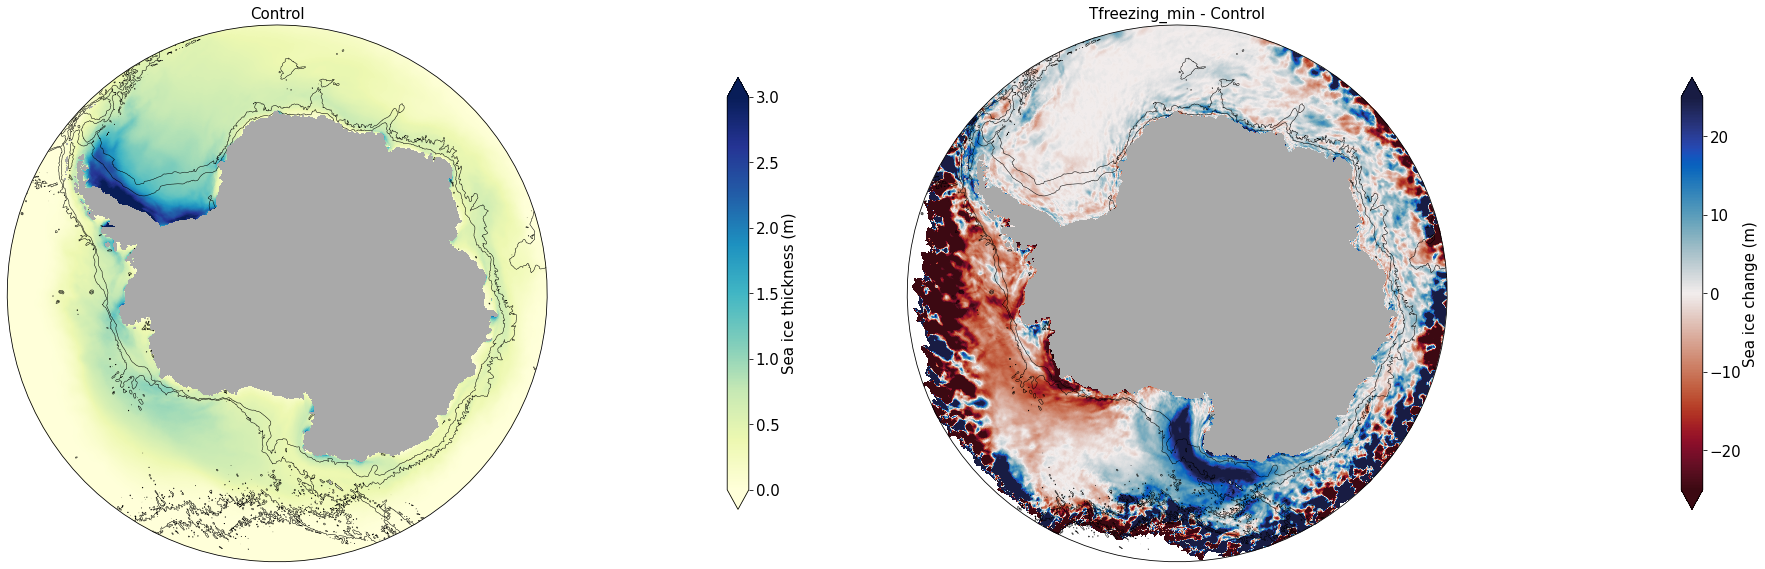

In [16]:
scale_max = 25

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)


# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, hi_con_avet, vmin=0,vmax=3,  
                   cmap = cmocean.cm.YlGnBu, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.4, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice thickness (m)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# Tfreezing_min
ax = fig.add_axes([0.5, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, (hi_Tfreezing_min_calv_2_avet-hi_con_avet)/hi_con_avet*100, norm = norm, 
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice change (m)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [18]:
#Time series

In [17]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [18]:
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
vi_con_shelf  = vi_con * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_con_shelf = vi_con_shelf.load()

vi_Tfreezing_min_calv_2_shelf  = vi_Tfreezing_min_calv_2 * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_Tfreezing_min_calv_2_shelf = vi_Tfreezing_min_calv_2_shelf.load()

In [19]:
vi_con_shelf_cpolar  = vi_con_shelf.sum('xt_ocean').sum('yt_ocean')
vi_Tfreezing_min_calv_2_shelf_cpolar = vi_Tfreezing_min_calv_2_shelf.sum('xt_ocean').sum('yt_ocean')

In [20]:
#Plotting

In [21]:
# Month labels
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Panel labels
panel_name = ['A', 'B', 'C', 'D', 'E', 'F']
# Font size
plt.rcParams['font.size'] = 14
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

(0.0, 8.0)

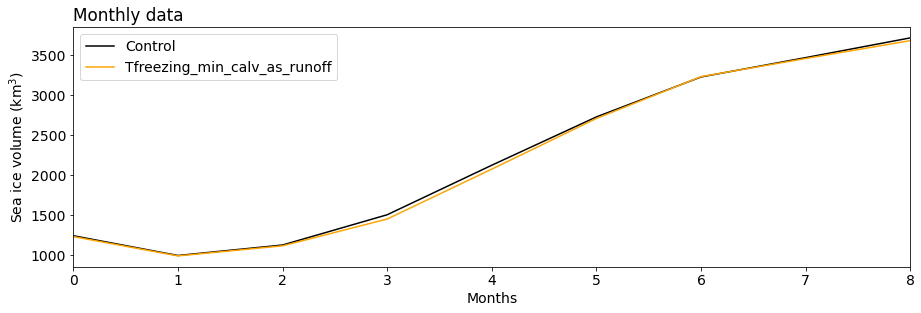

In [22]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly data', loc='left')
plt.plot(vi_con_shelf_cpolar, color='k', label='Control')
#plt.plot(vi_Tfreezing_insituS_shelf_cpolar, color='green', label='Tfreezing_insituS')
#plt.plot(vi_Tfreezing_zeroS_shelf_cpolar, color='blue', label='Tfreezing_zeroS')
#plt.plot(vi_Tfreezing_min_shelf_cpolar, color='red', label='Tfreezing_min')
#plt.plot(vi_Tfreezing_min_s0_shelf_cpolar, color='yellow', label='Tfreezing_min_s0')
#plt.plot(vi_nobasal_shelf_cpolar, color='magenta', label='nobasal')
#plt.plot(vi_Tfreezing_min_bg03_shelf_cpolar, color='green', label='Tfreezing_min_bg03')
#plt.plot(vi_Tfreezing_min_calvf_shelf_cpolar, color='cyan', label='Tfreezing_min_calv')
plt.plot(vi_Tfreezing_min_calv_2_shelf_cpolar, color='orange', label='Tfreezing_min_calv_as_runoff')

plt.legend()
plt.xlabel('Months')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,8)

NameError: name 'vi_con_shelf_cpolar_a' is not defined

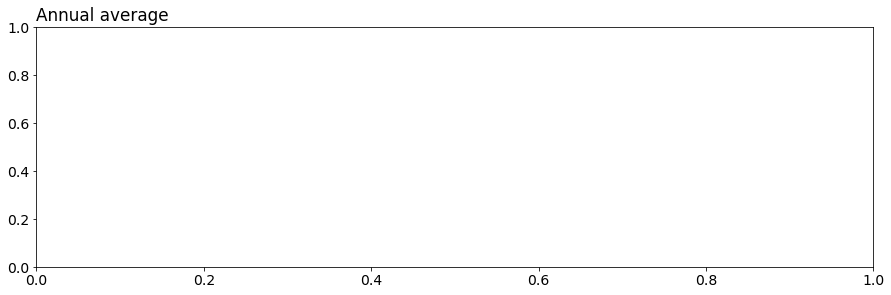

In [19]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Annual average', loc='left')
plt.plot(vi_con_shelf_cpolar_a, color='k', label='Control')
plt.plot(vi_Tfreezing_min_shelf_cpolar_a, color='C0', label='Tfreezing_min')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,5)

(0.0, 5.0)

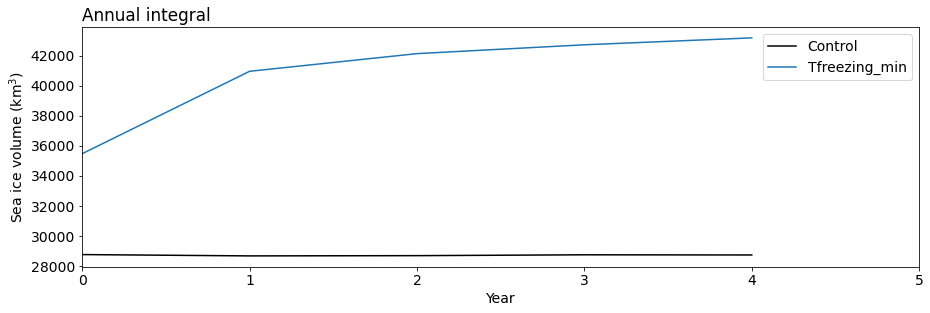

In [25]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Annual integral', loc='left')
plt.plot(vi_con_shelf_cpolar_sum, color='k', label='Control')
plt.plot(vi_Tfreezing_min_shelf_cpolar_sum, color='C0', label='Tfreezing_min')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,5)

In [7]:
#Thickness

In [19]:
#Import seaice
lat_slice = slice(-90,-59)
start_time='2154-01-01'
end_time='2155-01-01'

hi_con = cc.querying.getvar(control, 'hi_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_con = cc.querying.getvar(control, 'aice_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

hi_Tfreezing_min_s0 = cc.querying.getvar(Tfreezing_min_s0, 'hi_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_Tfreezing_min_s0 = cc.querying.getvar(Tfreezing_min_s0, 'aice_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

In [20]:
# Rename coordinates
# t-grid

# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

aice_con.coords['ni'] = area_t['xt_ocean'].values
aice_con.coords['nj'] = area_t['yt_ocean'].values
aice_con = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
hi_con.coords['ni'] = area_t['xt_ocean'].values
hi_con.coords['nj'] = area_t['yt_ocean'].values
hi_con = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

aice_Tfreezing_min_s0.coords['ni'] = area_t['xt_ocean'].values
aice_Tfreezing_min_s0.coords['nj'] = area_t['yt_ocean'].values
aice_Tfreezing_min_s0 = aice_Tfreezing_min_s0.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
hi_Tfreezing_min_s0.coords['ni'] = area_t['xt_ocean'].values
hi_Tfreezing_min_s0.coords['nj'] = area_t['yt_ocean'].values
hi_Tfreezing_min_s0 = hi_Tfreezing_min_s0.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

# Move time 12 hr forward to make sure it is in the correct month
aice_con['time'] = aice_con.time.to_pandas() - timedelta(hours = 12)
hi_con['time']   = hi_con.time.to_pandas() - timedelta(hours = 12)
    
aice_Tfreezing_min_s0['time'] = aice_Tfreezing_min_s0.time.to_pandas() - timedelta(hours = 12)
hi_Tfreezing_min_s0['time']   = hi_Tfreezing_min_s0.time.to_pandas() - timedelta(hours = 12)

In [26]:
area_t = area_t.sel(yt_ocean=lat_slice)

hi_con = hi_con.sel(yt_ocean=lat_slice)
aice_con = aice_con.sel(yt_ocean=lat_slice)

hi_Tfreezing_min_s0 = hi_Tfreezing_min_s0.sel(yt_ocean=lat_slice)
aice_Tfreezing_min_s0 = aice_Tfreezing_min_s0.sel(yt_ocean=lat_slice)

In [19]:
hi_con_spring = hi_con.mean('time').load()

hi_Tfreezing_min_s0_spring = hi_Tfreezing_min_s0.mean('time').load()

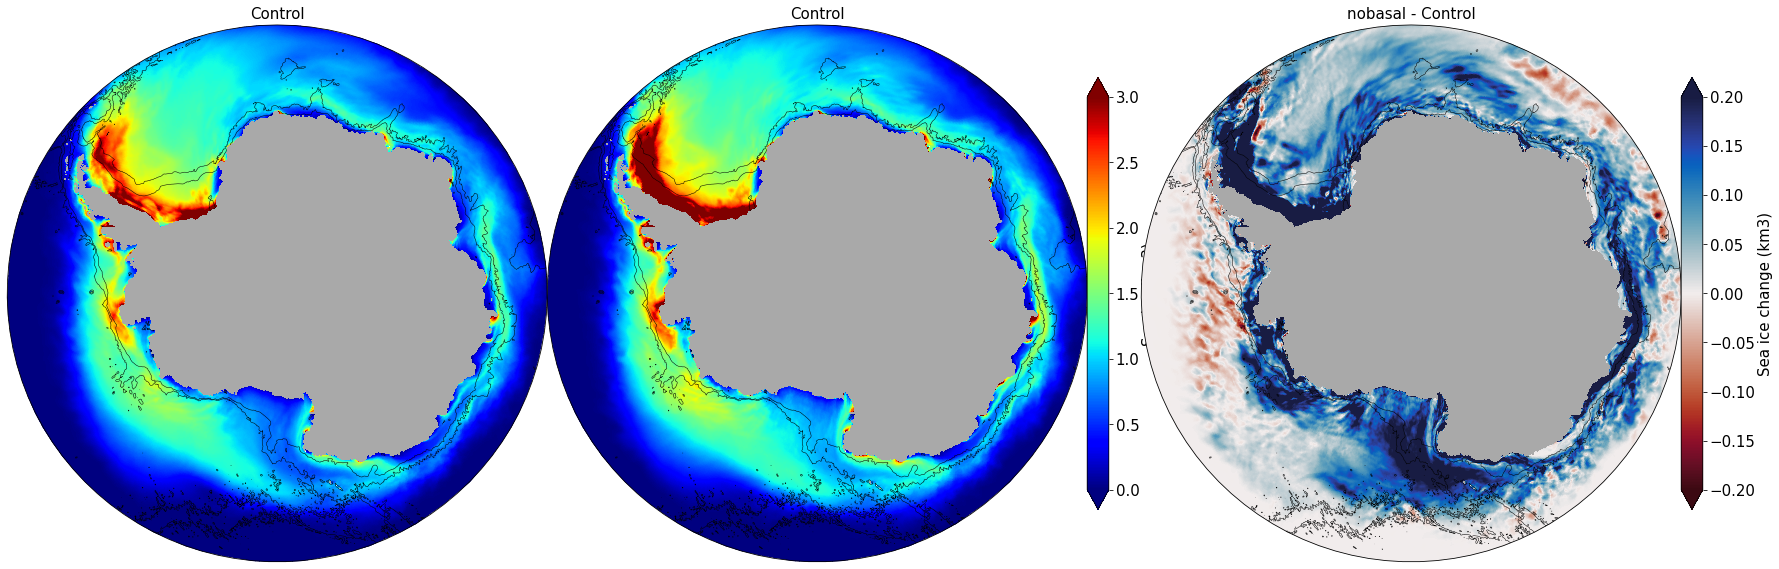

In [24]:
scale_max = .2

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)


# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, hi_con_spring, vmin=0,vmax=3,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.3, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, hi_Tfreezing_min_s0_spring, vmin=0,vmax=3,  
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.6, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

# nobasal
ax = fig.add_axes([0.63, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, hi_Tfreezing_min_s0_spring - hi_con_spring, norm = norm, 
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('nobasal - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice change (km3)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [10]:
#Cover area

In [13]:
import numpy.ma as ma

In [47]:
area_t = area_t.sel(yt_ocean=lat_slice)

aa = ma.masked_where(hi_con==0,hi_con)
cover_area = aa * area_t
bb = np.where(cover_area!=cover_area)
cover_area[bb] = 0
cover_area_sum_con = hi_con[:,0,0]*0
for tt in range(cover_area.shape[0]):
    cover_area_sum_con[tt] = cover_area[tt].sum()

In [48]:
aa = ma.masked_where(hi_Tfreezing_min_calv_2==0,hi_Tfreezing_min_calv_2)
cover_area = aa * area_t
bb = np.where(cover_area!=cover_area)
cover_area[bb] = 0
cover_area_sum_Tfreezing_min_calv_2 = hi_Tfreezing_min_calv_2[:,0,0]*0
for tt in range(cover_area.shape[0]):
    cover_area_sum_Tfreezing_min_calv_2[tt] = cover_area[tt].sum()

In [49]:
aa = ma.masked_where(hi_Tfreezing_min_calv==0,hi_Tfreezing_min_calv)
cover_area = aa * area_t
bb = np.where(cover_area!=cover_area)
cover_area[bb] = 0
cover_area_sum_Tfreezing_min_calv = hi_Tfreezing_min_calv[:,0,0]*0
for tt in range(cover_area.shape[0]):
    cover_area_sum_Tfreezing_min_calv[tt] = cover_area[tt].sum()

In [50]:
aa = ma.masked_where(hi_Tfreezing_min==0,hi_Tfreezing_min)
cover_area = aa * area_t
bb = np.where(cover_area!=cover_area)
cover_area[bb] = 0
cover_area_sum_Tfreezing_min = hi_Tfreezing_min[:,0,0]*0
for tt in range(cover_area.shape[0]):
    cover_area_sum_Tfreezing_min[tt] = cover_area[tt].sum()

Text(0.5, 1.0, 'Sea ice Area over the Antarctica')

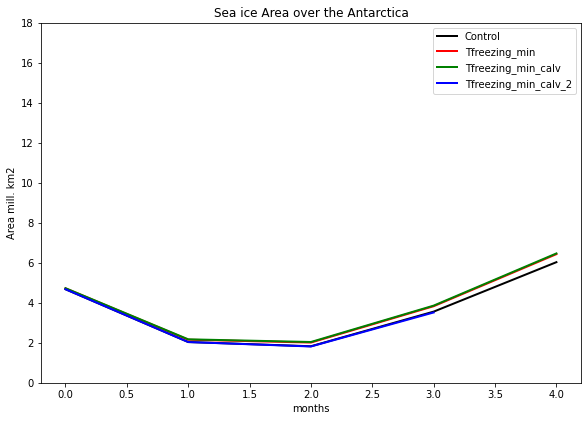

In [25]:
fig  = plt.figure(1, figsize = (25,5))
ax = fig.add_axes([0.0, 0.0, 0.3, 1])

ax.plot(cover_area_sum_con[0:5]/1e12,lw=2,color='k',label="Control")
ax.plot(cover_area_sum_Tfreezing_min[:]/1e12,lw=2,color='red',label='Tfreezing_min')
ax.plot(cover_area_sum_Tfreezing_min_calv[:]/1e12,lw=2,color='green',label='Tfreezing_min_calv')
ax.plot(cover_area_sum_Tfreezing_min_calv_2[:]/1e12,lw=2,color='blue',label='Tfreezing_min_calv_2')
plt.ylabel("Area mill. km2")
plt.xlabel("months")
plt.legend()
plt.ylim(ymin=0,ymax=18)
plt.title("Sea ice Area over the Antarctica")

Text(0.5, 1.0, 'Sea ice Area over the Antarctica')

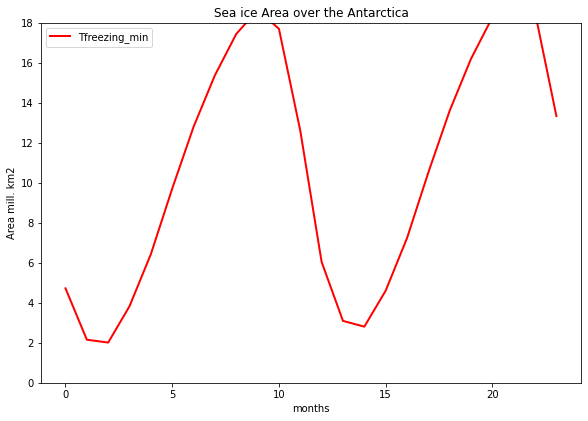

In [51]:
fig  = plt.figure(1, figsize = (25,5))
ax = fig.add_axes([0.0, 0.0, 0.3, 1])

ax.plot(cover_area_sum_Tfreezing_min[:]/1e12,lw=2,color='red',label='Tfreezing_min')
plt.ylabel("Area mill. km2")
plt.xlabel("months")
plt.legend()
plt.ylim(ymin=0,ymax=18)
plt.title("Sea ice Area over the Antarctica")

Text(0.5, 1.0, 'Sea ice Area over the Antarctica')

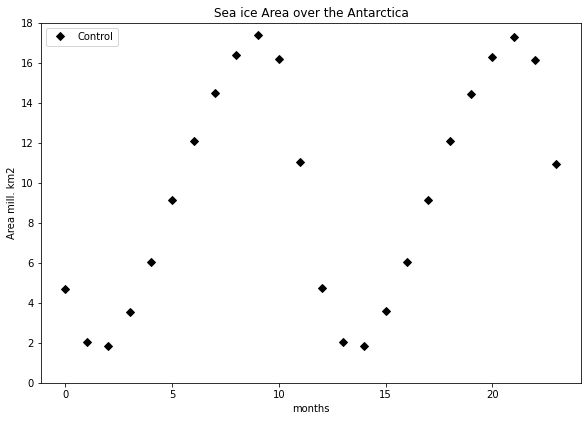

In [56]:
fig  = plt.figure(1, figsize = (25,5))
ax = fig.add_axes([0.0, 0.0, 0.3, 1])

ax.plot(cover_area_sum_con[:]/1e12,'D',lw=2,color='k',label="Control")
plt.ylabel("Area mill. km2")
plt.xlabel("months")
plt.legend()
plt.ylim(ymin=0,ymax=18)
plt.title("Sea ice Area over the Antarctica")